
# Calculate Stats for Step Current for Different Sets of Parameters 

In [1]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../')

In [2]:
from scipy.signal import argrelmin, argrelmax

In [3]:
from dap import DAPcython
from dap.utils import obs_params, load_current
from tqdm import tqdm
from scipy.spatial import distance

### Set Parameters

In [4]:
dt = 1e-2
params, labels = obs_params(reduced_model=False)
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

### load the file

In [5]:
# directory = './parameters/'
# dir = glob.glob(directory + '*')

# fname_start = dir[0].find('dap_')
# fname_stop = dir[0].find('n_')
# fname = dir[0][fname_start:fname_stop] + '.csv'

# df_param = pd.read_csv(fname)

In [6]:
df_param = pd.read_csv('dap_models_4_param_1x20.csv')

### calculate DAP

In [84]:
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

# define a model
dap = DAPcython(-75, params)

In [8]:
# run models on original parameters
U_step = dap.simulate(dts, ts, Is)
U_ramp = dap.simulate(dtr, tr, Ir)

### calculate the similarities

In [9]:
d_step = distance.euclidean(vs, U_step)
d_step

2628.5108865215593

In [10]:
d_ramp = distance.euclidean(vr, U_ramp)
d_ramp

509.7957382153249

In [11]:
d_step+d_ramp

3138.3066247368843

### run for all cells and save into the the DF

In [12]:
df_paramT = df_param.transpose()
df_paramT.head()

,0,1,2,3
Unnamed: 0,gbar_nap,gbar_leak,gbar_nat,gbar_kdr
1x14,17.1737,1.07467,131.423,3.41051
1x35,17.0972,1.03987,117.684,3.73748
1x9,19.0074,0.991425,95.3657,2.97607
1x19,16.3705,1.0285,141.775,3.43003


In [13]:
df_paramT.drop('Unnamed: 0', inplace=True)
df_paramT.head()

,0,1,2,3
1x14,17.1737,1.07467,131.423,3.41051
1x35,17.0972,1.03987,117.684,3.73748
1x9,19.0074,0.991425,95.3657,2.97607
1x19,16.3705,1.0285,141.775,3.43003
1x24,15.1533,1.10018,163.721,3.05554


In [14]:
daps = []
U_steps = []
U_ramps = []

for i, j in tqdm(df_paramT.iterrows()):
    # get parameters
    par_temp = j.values

    # define a model
    daps.append(DAPcython(-75, j))

    # run model
    U_steps.append(dap.simulate(dts, ts, Is))
    U_ramps.append(dap.simulate(dtr, tr, Ir))

34it [01:19,  2.48s/it]


## Specify the Features Function 

In [15]:
def calc_features_step(U, t, dt, t_on, t_off):
    v = U.copy()
    N = v.shape[0]

    # resting potential
    rest_pot = np.mean(v[t<t_on])
    rest_pot_std = np.std(v[int(.9*t_on/dt):int(t_on/dt)])  
 
    # put everything to -10 that is below -10 or has negative slope
    ind = np.where(v < -10)
    v[ind] = -10
    ind = np.where(np.diff(v) < 0)
    v[ind] = -10

    # remaining negative slopes are at spike peaks
    ind = np.where(np.diff(v) > 0)[0]
    print(ind)
    
    # choose one spike time within close spike times
    ind1 = np.array(ind)

    spike_times = np.array(t)[ind]
    spike_times_stim = spike_times[(spike_times > t_on)  & (spike_times < t_off)]
    ind_stim1 = ind1[(spike_times > t_on) & (spike_times < t_off)]
    ind_stim = ind_stim1.astype(int)

    firing_rate = 1e3*np.absolute(spike_times_stim.shape[0]/(t_off-t_on))
    time_1st_spike = spike_times_stim[spike_times_stim>t_on][0]

    ISI = np.diff(spike_times_stim).astype(float)

    
    sum_stats_vec = np.array([
                rest_pot,
                rest_pot_std,
                len(spike_times_stim),
                spike_times_stim,
                firing_rate,
                ISI.mean(),
                ISI.std()
                ])


    return sum_stats_vec

In [16]:
def flatten(U):
    v = U.copy()
    ind = np.where(v < -10)
    v[ind] = -10
    ind = np.where(np.diff(v) < 0)
    v[ind] = -10
    
    return v

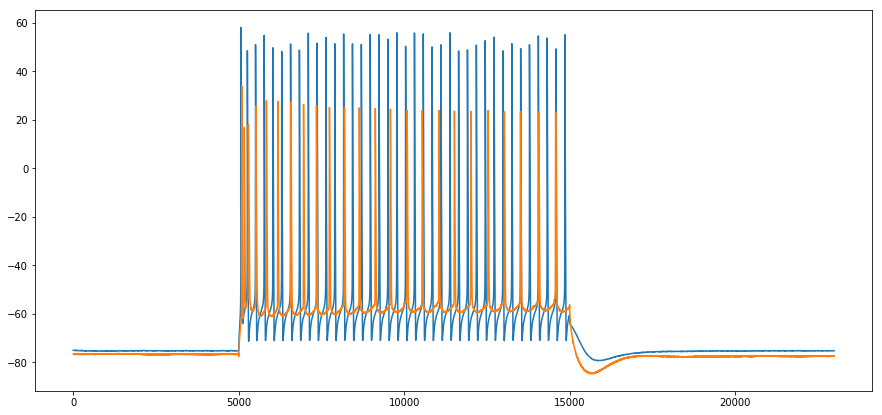

In [17]:
plt.figure(figsize=(15,7))
plt.plot(U_steps[0])
plt.plot(vs);

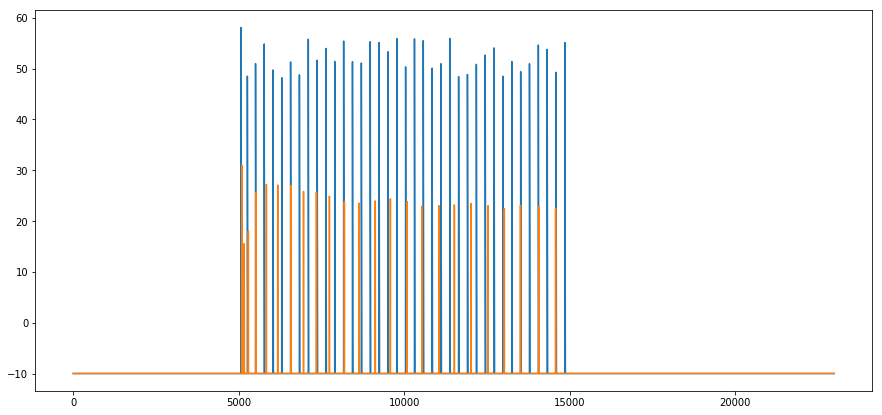

In [18]:
plt.figure(figsize=(15,7))
plt.plot(flatten(U_steps[0]))
plt.plot(flatten(vs));

In [19]:
x0 = calc_features_step(U_steps[0].transpose()[0], ts, dts, t_ons, t_offs)
x0

[ 5068  5070  5261  5508  5769  5770  6033  6034  6299  6300  6567  6833
  6834  7102  7103  7369  7634  7635  7902  8171  8173  8437  8438  8706
  8975  8977  9241  9242  9508  9509  9776  9777  9779 10043 10044 10311
 10312 10314 10577 10578 10843 10844 11112 11380 11382 11645 11646 11913
 12182 12450 12718 12984 12985 13254 13521 13522 13788 14056 14058 14323
 14589 14590 14858 14859]


array([-75.22335530690216, 0.027639488094157498, 64,
       array([253.4 , 253.5 , 263.05, 275.4 , 288.45, 288.5 , 301.65, 301.7 ,
       314.95, 315.  , 328.35, 341.65, 341.7 , 355.1 , 355.15, 368.45,
       381.7 , 381.75, 395.1 , 408.55, 408.65, 421.85, 421.9 , 435.3 ,
       448.75, 448.85, 462.05, 462.1 , 475.4 , 475.45, 488.8 , 488.85,
       488.95, 502.15, 502.2 , 515.55, 515.6 , 515.7 , 528.85, 528.9 ,
       542.15, 542.2 , 555.6 , 569.  , 569.1 , 582.25, 582.3 , 595.65,
       609.1 , 622.5 , 635.9 , 649.2 , 649.25, 662.7 , 676.05, 676.1 ,
       689.4 , 702.8 , 702.9 , 716.15, 729.45, 729.5 , 742.9 , 742.95]),
       128.0, 7.7706349206349214, 6.478944131352978], dtype=object)

In [20]:
x_orig = calc_features_step(vs.transpose(), ts, dts, t_ons, t_offs)
x_orig

[ 5090  5091  5092  5165  5166  5167  5168  5288  5289  5290  5291  5292
  5515  5516  5517  5518  5519  5834  5835  5836  5837  6177  6178  6179
  6180  6575  6576  6577  6578  6956  6957  6958  6959  7345  7346  7347
  7348  7349  7738  7739  7740  7741  7742  8192  8193  8194  8195  8640
  8641  8642  8643  9125  9126  9127  9128  9581  9582  9583  9584  9585
 10087 10088 10089 10090 10091 10544 10545 10546 10547 11048 11049 11050
 11051 11515 11516 11517 11518 11519 12015 12016 12017 12018 12019 12533
 12534 12535 12536 12537 13026 13027 13028 13029 13513 13514 13515 13516
 13517 14066 14067 14068 14069 14070 14574 14575 14576 14577 14578]


array([-76.63358125, 0.06351057982730121, 107,
       array([254.5 , 254.55, 254.6 , 258.25, 258.3 , 258.35, 258.4 , 264.4 ,
       264.45, 264.5 , 264.55, 264.6 , 275.75, 275.8 , 275.85, 275.9 ,
       275.95, 291.7 , 291.75, 291.8 , 291.85, 308.85, 308.9 , 308.95,
       309.  , 328.75, 328.8 , 328.85, 328.9 , 347.8 , 347.85, 347.9 ,
       347.95, 367.25, 367.3 , 367.35, 367.4 , 367.45, 386.9 , 386.95,
       387.  , 387.05, 387.1 , 409.6 , 409.65, 409.7 , 409.75, 432.  ,
       432.05, 432.1 , 432.15, 456.25, 456.3 , 456.35, 456.4 , 479.05,
       479.1 , 479.15, 479.2 , 479.25, 504.35, 504.4 , 504.45, 504.5 ,
       504.55, 527.2 , 527.25, 527.3 , 527.35, 552.4 , 552.45, 552.5 ,
       552.55, 575.75, 575.8 , 575.85, 575.9 , 575.95, 600.75, 600.8 ,
       600.85, 600.9 , 600.95, 626.65, 626.7 , 626.75, 626.8 , 626.85,
       651.3 , 651.35, 651.4 , 651.45, 675.65, 675.7 , 675.75, 675.8 ,
       675.85, 703.3 , 703.35, 703.4 , 703.45, 703.5 , 728.7 , 728.75,
       728.8 , 728.85, 

### Fix the amount of spikes detected

In [22]:
# resting potential
rest_pot = np.mean(v[t<t_on])
rest_pot_std = np.std(v[int(.9*t_on/dt):int(t_on/dt)])  

# put everything to -10 that is below -10 or has negative slope
ind = np.where(v < -10)
v[ind] = -10
ind = np.where(np.diff(v) < 0)
v[ind] = -10

# remaining negative slopes are at spike peaks
ind = np.where(np.diff(v) > 0)[0]

In [23]:
x = np.diff(ind)
y = (x[x>1])
y

array([ 73, 120, 223, 315, 340, 395, 378, 386, 389, 450, 445, 482, 453,
       502, 453, 501, 464, 496, 514, 489, 484, 549, 504])

In [105]:
def find_spikes(U):
    v = U.copy()
    # look for non-resting potential values
    ind = np.where(v < -10)
    v[ind] = -10
    ind = np.where(np.diff(v) < 0)
    v[ind] = -10

    # look for all slope changes
    v = (np.diff(v) > 0).astype(int)

    # get all change of slopes indices
    v_ind = np.where(np.diff(np.sign(v)))[0]
    
    # return last positive change of slope 
    return v_ind[1::2]


In [106]:
t = find_spikes(vs)
x = np.zeros_like(t)

array([ 5090,  5166,  5290,  5517,  5835,  6178,  6576,  6957,  7347,
        7740,  8193,  8641,  9126,  9583, 10089, 10545, 11049, 11517,
       12017, 12535, 13027, 13515, 14068, 14576])

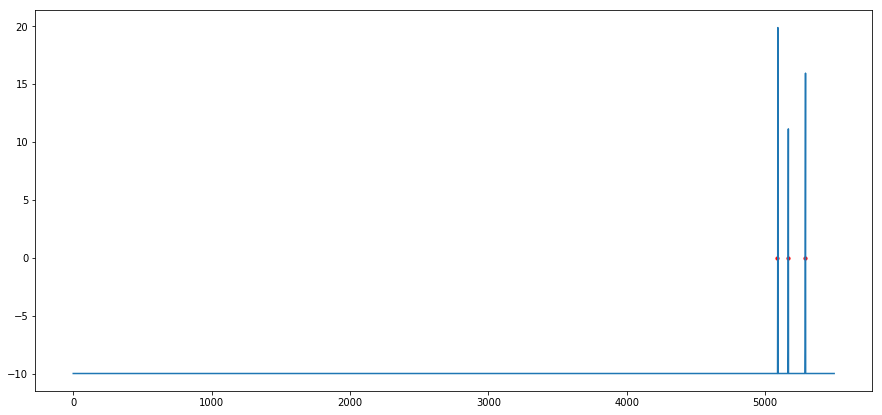

In [108]:
plt.figure(figsize=(15,7))
plt.scatter(t[:3]-2, x[:3], c='r', s=10);
plt.plot(vs[0:5500]);

In [123]:
U_steps[0].transpose()[0]

array([-74.99236374, -74.98643001, -74.99417885, ..., -75.22342786,
       -75.24368539, -75.24330581])

In [128]:
t = find_spikes(U_steps[0].transpose()[0]) -2
t

array([ 5066,  5068,  5259,  5506,  5768,  6032,  6298,  6565,  6832,
        7101,  7367,  7633,  7900,  8169,  8171,  8436,  8704,  8973,
        8975,  9240,  9507,  9775,  9777, 10042, 10310, 10312, 10576,
       10842, 11110, 11378, 11380, 11644, 11911, 12180, 12448, 12716,
       12983, 13252, 13520, 13786, 14054, 14056, 14321, 14588, 14857])

In [131]:
x = np.zeros_like(t)
len(x)

45

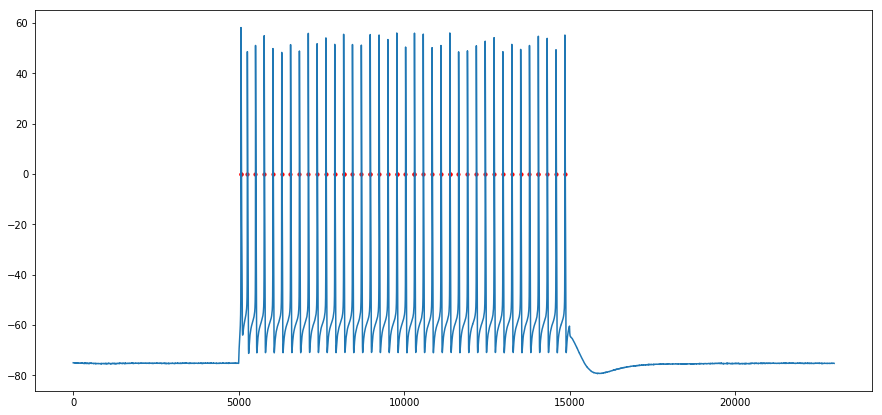

In [130]:
plt.figure(figsize=(15,7))
plt.scatter(t, x, c='r', s=10);
plt.plot(U_steps[0]);